# PGS CTD Biota ADCP tutorial

In [ ]:
!pip install -U odp-sdk --quiet && pip list | grep odp

## 1.1 Setup ODP Client

In [1]:
from odp.client import OdpClient # The SDK

import pandas as pd
import matplotlib.pyplot as plt
import pydeck as pdk
from shapely.geometry import box, LineString, mapping


### 1.2 Pydeck Plot Helper

In [2]:
from shapely import wkt

def convert_geometry_field(data):
    for item in data:
        try:
            geom = wkt.loads(item["geometry"])
            if geom.geom_type == "Point":
                item["geometry"] = {
                    "type": "Point",
                    "coordinates": [geom.x, geom.y]
                }
            elif geom.geom_type == "MultiLineString":
                item["geometry"] = {
                    "type": "MultiLineString",
                    "coordinates": [
                        [list(coord) for coord in line.coords]
                        for line in geom.geoms
                    ]
                }
            elif geom.geom_type == "LineString":
                item["geometry"] = {
                    "type": "LineString",
                    "coordinates": [list(coord) for coord in geom.coords]
                }

        except Exception as e:
            pass

    return data


### 1.3 Geometric Plot Helper

In [3]:
# loading a simple function to make a nice map display of points
def simple_pydeck_plot(geojson_lists, size=1, lat=0, lon=0, zoom=2):
    colors = [(3, 255, 209), (255, 216, 11), (157, 89, 244), (254, 119, 76)]  # Cyan, Yellow, Purple, Orange
    layers = []
    for i, geojson_list in enumerate(geojson_lists):
        layer = pdk.Layer("GeoJsonLayer", data=convert_geometry_field(geojson_list), lineWidthMinPixels=size, pointRadiusMinPixels=size, pickable=True, get_line_color=colors[i % len(colors)], get_fill_color=colors[i % len(colors)],)
        layers.append(layer)
    r = pdk.Deck(layers=layers, initial_view_state=(pdk.ViewState(latitude=lat, longitude=lon, zoom=zoom)), map_provider="mapbox", map_style='mapbox://styles/oceandatafoundation/clwg6xklg00an01pcgmeufjxq', api_keys={'mapbox': 'pk.eyJ1Ijoib2NlYW5kYXRhZm91bmRhdGlvbiIsImEiOiJjazk5bGxpNWkwYWU1M2Vya3hkcHh4czdrIn0.yf7kIiPfDNE7KP9_9wTN6A'})
    return r

In [4]:
client = OdpClient()

### 2.1 Fetch Metadata from Catalog
- Option 1) via API calls to the catalog
- Option 2) getting UUID from the landing page:
https://app.hubocean.earth/catalog/dataset/1e3401d4-9630-40cd-a9cf-d875cb310449-mammals_survey_concentrated
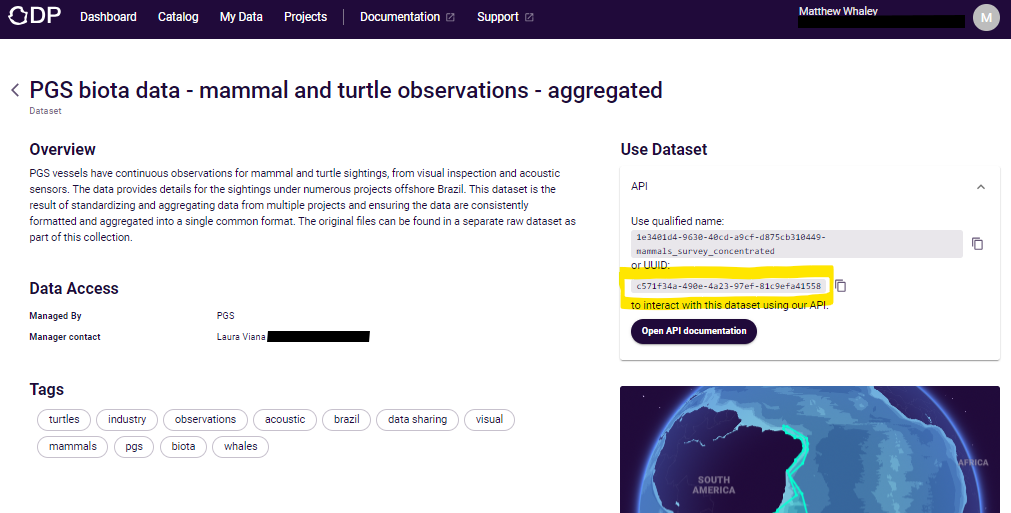

#### 2.2 Create a geospatial query
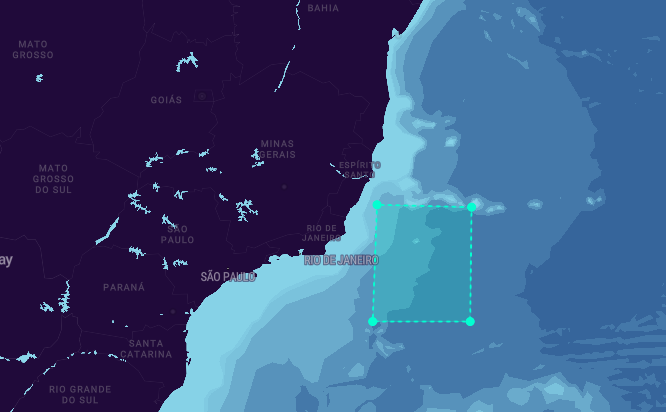

In [5]:
bbox_lat_min = -26
bbox_lat_max = -21
bbox_lon_min = -40
bbox_lon_max = -35

query_geometry = box(
    bbox_lon_min, bbox_lat_min,
    bbox_lon_max, bbox_lat_max
).wkt

### 3.2.1 Turn bounding box into format the can be plotted

In [6]:
bbox_geom = box(bbox_lon_min, bbox_lat_min, bbox_lon_max, bbox_lat_max)

coords = list(bbox_geom.exterior.coords)

lines = [
    LineString([coords[0], coords[1]]),  # bottom
    LineString([coords[1], coords[2]]),  # right
    LineString([coords[2], coords[3]]),  # top
    LineString([coords[3], coords[0]])   # left
]

bbox_list = [
    {
        "type": "Feature",
        "geometry": mapping(line),
        "properties": {"edge": i}
    }
    for i, line in enumerate(lines)
]

## 3.3 Fetch data


### 3.3.1 Fetch data with geospatial query

In [7]:
ctd = client.catalog.get("7f93ce41-e2ae-4f41-af41-fd7f017efd31")
print(ctd.metadata.display_name)

ctd_dataset = client.table_v2(ctd)

pages = list(
    ctd_dataset
      .select(f"geometry within '{query_geometry}' AND Depth_m < 5")
      .pages()
)

CTD_data = [row for page in pages for row in page]

PGS physics data - CTD profiles - aggregated


### 3.3.2 Fetch data with geospatial query

In [8]:
biota = client.catalog.get("ce1065c4-f9eb-4533-8e9a-55621f227709")
print(biota.metadata.display_name)

# 2) Switch to the new table_v2 interface
biota_dataset = client.table_v2(biota)

# 3) Pull pages of only those features whose geometry lies within your bbox
pages = list(
    biota_dataset
      .select(f"geometry within '{query_geometry}'")
      .pages()
)

# 4) Flatten pages into a single list of row‑dicts
biota_data = [row for page in pages for row in page]

PGS biota data - mammal and turtle observations - aggregated


## 4.1 Visualize data

### 4.1.1 Plot datapoints from queries on a map with bounding box

In [9]:
simple_pydeck_plot([CTD_data, biota_data, bbox_list], zoom=6, lat=-23, lon=-39)

{
  "initialViewState": {
    "latitude": -23,
    "longitude": -39,
    "zoom": 6
  },
  "layers": [
    {
      "@@type": "GeoJsonLayer",
      "data": [
        {
          "Conduct_mS/cm": 54.79,
          "DatetimeUtc": {},
          "Density_sigma-T": 25.215,
          "Depth_m": 1.71,
          "Pressure_dBar": null,
          "ProfileName": "TS_Dip_2022001.xlsm_Profile # 12",
          "Project": "Tethys - Roncador",
          "Salinity_ppm": 37.08,
          "Temp_C": 24.029,
          "Velocity_ms-1": 1534.31,
          "geometry": {
            "coordinates": [
              -39.6875,
              -21.854333
            ],
            "type": "Point"
          }
        },
        {
          "Conduct_mS/cm": 55.03,
          "DatetimeUtc": {},
          "Density_sigma-T": 25.283,
          "Depth_m": 3.03,
          "Pressure_dBar": null,
          "ProfileName": "TS_Dip_2022001.xlsm_Profile # 12",
          "Project": "Tethys - Roncador",
          "Salinity_ppm": 37.19,
          "Temp_C": 24.11,
          "Velocity_ms-1": 1534.66,
          "geometry": {
            "coordinates": [
              -39.6875,
              -21.854333
            ],
            "type": "Point"
          }
        },
        {
          "Conduct_mS/cm": 55.04,
          "DatetimeUtc": {},
          "Density_sigma-T": 25.268,
          "Depth_m": 4.0,
          "Pressure_dBar": null,
          "ProfileName": "TS_Dip_2022001.xlsm_Profile # 12",
          "Project": "Tethys - Roncador",
          "Salinity_ppm": 37.18,
          "Temp_C": 24.137,
          "Velocity_ms-1": 1534.72,
          "geometry": {
            "coordinates": [
              -39.6875,
              -21.854333
            ],
            "type": "Point"
          }
        },
        {
          "Conduct_mS/cm": 55.05,
          "DatetimeUtc": {},
          "Density_sigma-T": 25.268,
          "Depth_m": 4.93,
          "Pressure_dBar": null,
          "ProfileName": "TS_Dip_2022001.xlsm_Profile # 12",
          "Project": "Tethys - Roncador",
          "Salinity_ppm": 37.17,
          "Temp_C": 24.147,
          "Velocity_ms-1": 1534.76,
          "geometry": {
            "coordinates": [
              -39.6875,
              -21.854333
            ],
            "type": "Point"
          }
        },
        {
          "Conduct_mS/cm": 55.21,
          "DatetimeUtc": {},
          "Density_sigma-T": 25.287,
          "Depth_m": 4.32,
          "Pressure_dBar": null,
          "ProfileName": "TS_Dip_2022001.xlsm_Profile # 12",
          "Project": "Tethys - Roncador",
          "Salinity_ppm": 37.23,
          "Temp_C": 24.223,
          "Velocity_ms-1": 1535.0,
          "geometry": {
            "coordinates": [
              -39.6875,
              -21.854333
            ],
            "type": "Point"
          }
        },
        {
          "Conduct_mS/cm": 55.2,
          "DatetimeUtc": {},
          "Density_sigma-T": 25.275,
          "Depth_m": 2.99,
          "Pressure_dBar": null,
          "ProfileName": "TS_Dip_2022001.xlsm_Profile # 12",
          "Project": "Tethys - Roncador",
          "Salinity_ppm": 37.23,
          "Temp_C": 24.224,
          "Velocity_ms-1": 1534.97,
          "geometry": {
            "coordinates": [
              -39.6875,
              -21.854333
            ],
            "type": "Point"
          }
        },
        {
          "Conduct_mS/cm": 55.21,
          "DatetimeUtc": {},
          "Density_sigma-T": 25.279,
          "Depth_m": 2.51,
          "Pressure_dBar": null,
          "ProfileName": "TS_Dip_2022001.xlsm_Profile # 12",
          "Project": "Tethys - Roncador",
          "Salinity_ppm": 37.23,
          "Temp_C": 24.224,
          "Velocity_ms-1": 1534.97,
          "geometry": {
            "coordinates": [
              -39.6875,
              -21.854333
            ],
            "type": "Point"
          }
        },
        {
          "Conduct_mS/cm": 55.21,
          "DatetimeUtc": {},
         

## 5.1 Inspect data
### 5.1.1 Option 1): work with list of datapoints

In [10]:
#inspecting the fifth item of the list (numbering starts from 0)
biota_data[4:5]

[{'Juveniles': 1.0,
  'Bathymetry': 2895.0,
  'Duration': 26.0,
  'geometry': {'type': 'Point', 'coordinates': [-39.726, -23.14066]},
  'DateTimeStartedGMT-3': Timestamp('2020-03-15 08:51:00'),
  'Species': 'Grampus griseus',
  'Adults': 14.0,
  'Family': '',
  'Acoustic': False}]

### 5.1.2 Option 2): convert from the list to a pandas dataframe

In [11]:
pd.DataFrame(biota_data).head()

,Juveniles,Bathymetry,Duration,geometry,DateTimeStartedGMT-3,Species,Adults,Family,Acoustic
0,2.0,2985.0,5.0,"{'type': 'Point', 'coordinates': [-39.74145, -...",2020-03-01 10:50:00,Stenella attenuata,8.0,,False
1,0.0,2087.0,3.0,"{'type': 'Point', 'coordinates': [-39.66613, -...",2020-03-05 06:00:00,Delphinidae,2.0,,False
2,2.0,2021.0,31.0,"{'type': 'Point', 'coordinates': [-39.66597, -...",2020-03-06 15:11:00,Stenella attenuata,58.0,,False
3,0.0,2050.0,12.0,"{'type': 'Point', 'coordinates': [-39.76545, -...",2020-03-07 12:51:00,Delphinidae,3.0,,False
4,1.0,2895.0,26.0,"{'type': 'Point', 'coordinates': [-39.726, -23...",2020-03-15 08:51:00,Grampus griseus,14.0,,False


### 5.1.3 Option 3): use 'select().dataframes()' function of the SDK

In [12]:
df_geo = pd.concat(biota_dataset.select(f"geometry within '{query_geometry}'").dataframes(), ignore_index=True)
df_geo.head()

,Juveniles,Bathymetry,Duration,geometry,DateTimeStartedGMT-3,Species,Adults,Family,Acoustic
0,2.0,2985.0,5.0,POINT (-39.74145 -22.06701),2020-03-01 10:50:00,Stenella attenuata,8.0,,False
1,0.0,2087.0,3.0,POINT (-39.66613 -22.40901),2020-03-05 06:00:00,Delphinidae,2.0,,False
2,2.0,2021.0,31.0,POINT (-39.66597 -22.16733),2020-03-06 15:11:00,Stenella attenuata,58.0,,False
3,0.0,2050.0,12.0,POINT (-39.76545 -22.47878),2020-03-07 12:51:00,Delphinidae,3.0,,False
4,1.0,2895.0,26.0,POINT (-39.726 -23.14066),2020-03-15 08:51:00,Grampus griseus,14.0,,False


## 6.1 Plot detailed CTD data

### 6.1.1 Geospatial query and get data directly to dataframe

In [13]:
ctd_dataset = client.table_v2(ctd)

CTD_df = pd.concat(ctd_dataset.select(f"geometry within '{query_geometry}'").dataframes(), ignore_index=True)

In [14]:
CTD_df.head()

,Salinity_ppm,Depth_m,Project,Velocity_ms-1,Conduct_mS/cm,DatetimeUtc,geometry,Temp_C,ProfileName,Density_sigma-T,Pressure_dBar
0,37.08,1.71,Tethys - Roncador,1534.31,54.79,2022-07-30 13:33:17,POINT (-39.6875 -21.854333),24.029,TS_Dip_2022001.xlsm_Profile # 12,25.215,NaN
1,37.19,3.03,Tethys - Roncador,1534.66,55.03,2022-07-30 13:33:18,POINT (-39.6875 -21.854333),24.110,TS_Dip_2022001.xlsm_Profile # 12,25.283,NaN
2,37.18,4.00,Tethys - Roncador,1534.72,55.04,2022-07-30 13:33:19,POINT (-39.6875 -21.854333),24.137,TS_Dip_2022001.xlsm_Profile # 12,25.268,NaN
3,37.17,4.93,Tethys - Roncador,1534.76,55.05,2022-07-30 13:33:20,POINT (-39.6875 -21.854333),24.147,TS_Dip_2022001.xlsm_Profile # 12,25.268,NaN
4,37.18,5.96,Tethys - Roncador,1534.80,55.06,2022-07-30 13:33:21,POINT (-39.6875 -21.854333),24.154,TS_Dip_2022001.xlsm_Profile # 12,25.271,NaN


### 6.2 Plot data

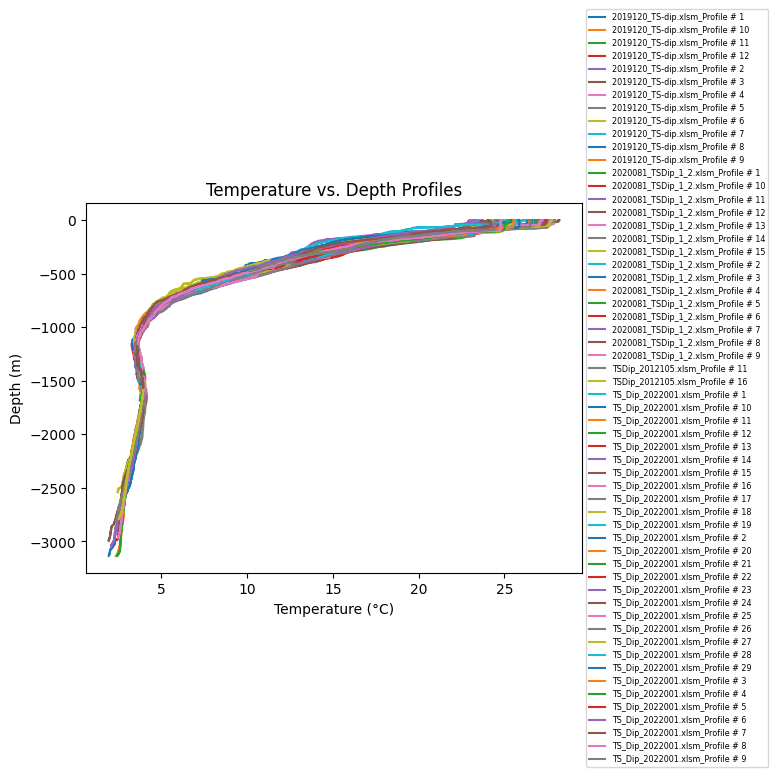

In [15]:
groupedCTD = CTD_df.groupby('ProfileName')
for name, group in groupedCTD:
    plt.plot(group['Temp_C'], group['Depth_m']*-1, label=name)
plt.xlabel('Temperature (°C)')
plt.ylabel('Depth (m)')
plt.title('Temperature vs. Depth Profiles')
plt.legend(fontsize='xx-small', loc='center left', bbox_to_anchor=(1, 0.5))  # Set the legend font size to 'small'
plt.show()